In [2]:
!pip install numpy

In [3]:
!pip install efficientnet 


In [4]:
!pip install seaborn

In [27]:
pip install tensorflow==2.7.0

     |███████████████████▍            | 297.0 MB 122.2 MB/s eta 0:00:02

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 489.6 MB 16 kB/s 
     |████████████████████████████████| 1.3 MB 87.1 MB/s eta 0:00:01
     |████████████████████████████████| 463 kB 112.0 MB/s eta 0:00:01
ERROR: tensorflow-gpu 2.8.0 has requirement keras<2.9,>=2.8.0rc0, but you'll have keras 2.7.0 which is incompatible.
ERROR: tensorflow-cpu 2.2.1 has requirement h5py<2.11.0,>=2.10.0, but you'll have h5py 3.7.0 which is incompatible.
ERROR: tensorflow-cpu 2.2.1 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.21.6 which is incompatible.
ERROR: tensorflow-cpu 2.2.1 has requirement tensorboard<2.3.0,>=2.2.0, but you'll have tensorboard 2.8.0 which is incompatible.
ERROR: tensorflow-cpu 2.2.1 has requirement tensorflow-estimator<2.3.0,>=2.2.0, but you'll have tensorflow-estimator 2.7.0 which is incompatible.
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: tenso

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [6]:
import pandas as pd, numpy as np
# from kaggle_datasets import KaggleDatasets
import tensorflow as tf, re, math
from tensorflow.keras import Model
from tensorflow.keras.layers import (Dropout,
                                     Conv2D,
                                     BatchNormalization,
                                     Dense,
                                     GlobalAveragePooling2D,
                                     Input,
                                     Activation,
                                     Lambda,
                                     multiply)
import tensorflow.keras.backend as K
import efficientnet.tfkeras as efn
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

In [10]:
# DEVICE = "TPU" #or "GPU"
DEVICE = "GPU"

# USE DIFFERENT SEED FOR DIFFERENT STRATIFIED KFOLD
SEED = 42

# NUMBER OF FOLDS. USE 3, 5, OR 15 
#FOLDS = 5
FOLDS = 4


# WHICH IMAGE SIZES TO LOAD EACH FOLD
# CHOOSE 128, 192, 256, 384, 512, 768 
#IMG_SIZES = [384,384,384,384,384]
IMG_SIZES = [384,384,384,]

# INCLUDE OLD COMP DATA? YES=1 NO=0
INC2019 = [0,0,0,0,0]
INC2018 = [1,1,1,1,1]

# BATCH SIZE AND EPOCHS
# BATCH_SIZES = [32]*FOLDS
#BATCH_SIZES = [8]*FOLDS
BATCH_SIZES = [16]*FOLDS
# EPOCHS = [15]*FOLDS
#EPOCHS = [5]*FOLDS
EPOCHS = [10]*FOLDS

# WHICH EFFICIENTNET B? TO USE
EFF_NETS = [6,6,6,6,6]

# WEIGHTS FOR FOLD MODELS WHEN PREDICTING TEST
WGTS = [1/FOLDS]*FOLDS

# TEST TIME AUGMENTATION STEPS
TTA = 11

In [11]:
if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    strategy = tf.distribute.MirroredStrategy()

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

Using default strategy for CPU and single GPU
Num GPUs Available:  2
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
REPLICAS: 2


In [29]:
#!pwd
#!cd melanoma
#!pwd

/home/azureadmin/notebooks
/home/azureadmin/notebooks


In [12]:
GCS_PATH = [None]*FOLDS; GCS_PATH2 = [None]*FOLDS
for i,k in enumerate(IMG_SIZES):
    GCS_PATH[i] = '/home/azureadmin/notebooks/data/melanoma'
    GCS_PATH2[i] = '/home/azureadmin/notebooks/data/isic'
#     print(' - ',GCS_PATH[i])
files_train = np.sort(np.array(tf.io.gfile.glob(GCS_PATH[0] + '/train*.tfrec')))
files_test  = np.sort(np.array(tf.io.gfile.glob(GCS_PATH[0] + '/test*.tfrec')))
print(files_train)
print(files_test)

['/home/azureadmin/notebooks/data/melanoma/train00-2182.tfrec'
 '/home/azureadmin/notebooks/data/melanoma/train01-2185.tfrec'
 '/home/azureadmin/notebooks/data/melanoma/train02-2193.tfrec'
 '/home/azureadmin/notebooks/data/melanoma/train03-2182.tfrec'
 '/home/azureadmin/notebooks/data/melanoma/train04-2167.tfrec'
 '/home/azureadmin/notebooks/data/melanoma/train05-2171.tfrec'
 '/home/azureadmin/notebooks/data/melanoma/train06-2175.tfrec'
 '/home/azureadmin/notebooks/data/melanoma/train07-2174.tfrec'
 '/home/azureadmin/notebooks/data/melanoma/train08-2177.tfrec'
 '/home/azureadmin/notebooks/data/melanoma/train09-2178.tfrec'
 '/home/azureadmin/notebooks/data/melanoma/train10-2174.tfrec'
 '/home/azureadmin/notebooks/data/melanoma/train11-2176.tfrec'
 '/home/azureadmin/notebooks/data/melanoma/train12-2198.tfrec'
 '/home/azureadmin/notebooks/data/melanoma/train13-2186.tfrec'
 '/home/azureadmin/notebooks/data/melanoma/train14-2174.tfrec']
['/home/azureadmin/notebooks/data/melanoma/test00-687.

In [13]:
ROT_ = 180.0
SHR_ = 2.0
HZOOM_ = 8.0
WZOOM_ = 8.0
HSHIFT_ = 8.0
WSHIFT_ = 8.0

In [14]:
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear    = math.pi * shear    / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    # ROTATION MATRIX
    c1   = tf.math.cos(rotation)
    s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
    rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
                                   -s1,  c1,   zero, 
                                   zero, zero, one])    
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)    
    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                                zero, c2,   zero, 
                                zero, zero, one])        
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), 
                 K.dot(zoom_matrix,     shift_matrix))


def transform(image, DIM=256):    
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    XDIM = DIM%2 #fix for size 331
    
    rot = ROT_ * tf.random.normal([1], dtype='float32')
    shr = SHR_ * tf.random.normal([1], dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / HZOOM_
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / WZOOM_
    h_shift = HSHIFT_ * tf.random.normal([1], dtype='float32') 
    w_shift = WSHIFT_ * tf.random.normal([1], dtype='float32') 

    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x   = tf.repeat(tf.range(DIM//2, -DIM//2,-1), DIM)
    y   = tf.tile(tf.range(-DIM//2, DIM//2), [DIM])
    z   = tf.ones([DIM*DIM], dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m, tf.cast(idx, dtype='float32'))
    idx2 = K.cast(idx2, dtype='int32')
    idx2 = K.clip(idx2, -DIM//2+XDIM+1, DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack([DIM//2-idx2[0,], DIM//2-1+idx2[1,]])
    d    = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM, DIM,3])

In [15]:
def read_labeled_tfrecord(example):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
        'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
        'diagnosis'                    : tf.io.FixedLenFeature([], tf.int64),
        'target'                       : tf.io.FixedLenFeature([], tf.int64)
    }           
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['target']


def read_unlabeled_tfrecord(example, return_image_name):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['image_name'] if return_image_name else 0

 
def prepare_image(img, augment=True, dim=256):    
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0
    
    if augment:
        img = transform(img,DIM=dim)
        img = tf.image.random_flip_left_right(img)
        #img = tf.image.random_hue(img, 0.01)
        img = tf.image.random_saturation(img, 0.7, 1.3)
        img = tf.image.random_contrast(img, 0.8, 1.2)
        img = tf.image.random_brightness(img, 0.1)
                      
    img = tf.reshape(img, [dim,dim, 3])
            
    return img

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

In [16]:
def get_dataset(files, augment = False, shuffle = False, repeat = False, 
                labeled=True, return_image_names=True, batch_size=16, dim=256):
    
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    ds = ds.cache()
    
    if repeat:
        ds = ds.repeat()
    
    if shuffle: 
        ds = ds.shuffle(1024*8)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
        
    if labeled: 
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    else:
        ds = ds.map(lambda example: read_unlabeled_tfrecord(example, return_image_names), 
                    num_parallel_calls=AUTO)      
    
    ds = ds.map(lambda img, imgname_or_label: (prepare_image(img, augment=augment, dim=dim), 
                                               imgname_or_label), 
                num_parallel_calls=AUTO)
    
    ds = ds.batch(batch_size * REPLICAS)
    ds = ds.prefetch(AUTO)
    return ds


In [17]:
EFNS = [efn.EfficientNetB0, efn.EfficientNetB1, efn.EfficientNetB2, efn.EfficientNetB3, efn.EfficientNetB4, efn.EfficientNetB5, efn.EfficientNetB6]

def build_model(dim = 128, ef = 0):
    ### Base Model ###
    # Input
    inp = Input(shape = (dim, dim, 3))
    # Base EfficientNet pretrained model
    base = EFNS[ef](
        input_shape = (dim, dim, 3),
        weights = "imagenet",
        include_top = False,
        drop_connect_rate = 0.3
    )
#     print('base :: ', base.summary())
#     print('get_output_shape_at :: ', base.layers[0].compute_output_shape((dim, dim, 3))[-1])
#     print('get_output_shape_at :: ',  base.layers[-1].output_shape[-1])
    # variables for the attention mechanism and later
#     pt_depth = base.get_output_shape_at(0)[-1]
    pt_depth = base.layers[-1].output_shape[-1]
    pt_features = base(inp)
    bn_features = BatchNormalization()(pt_features)

    ### Attention Mechanism ###
    attn_layer = Conv2D(64, kernel_size = (1, 1), padding = "same", activation = "relu")(Dropout(0.5)(bn_features))
    attn_layer = Conv2D(16, kernel_size = (1, 1), padding = "same", activation = "relu")(attn_layer)
    attn_layer = Conv2D(8, kernel_size = (1, 1), padding = "same", activation = "relu")(attn_layer)
    attn_layer = Conv2D(1, kernel_size = (1, 1), padding = "valid", activation = "sigmoid")(attn_layer)

    # Fan it out to all of the channels
    up_c2_w = np.ones((1, 1, 1, pt_depth))
    up_c2 = Conv2D(
        pt_depth, kernel_size = (1, 1),
        padding = "same",
        activation = "linear",
        use_bias = False,
        weights = [up_c2_w]
    )
    up_c2.trainable = False
    attn_layer = up_c2(attn_layer)

    mask_features = multiply([attn_layer, bn_features])
    gap_features = GlobalAveragePooling2D()(mask_features)
    gap_mask = GlobalAveragePooling2D()(attn_layer)

    # To account for missing values from the attention model
    gap = Lambda(lambda x: x[0] / x[1], name = "RescaleGAP")([gap_features, gap_mask])
    gap_dr = Dropout(0.25)(gap)
    dr_steps = Dropout(0.25)(Dense(128, activation = "relu")(gap_dr))

    ### Rebuild top ###
    x = Dense(1, activation = "sigmoid")(dr_steps)

    ### Compile ###
    model = Model(inputs = inp, outputs = x)
    # Optimizer
    opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
    # Loss
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.05) 
    model.compile(optimizer = opt, loss = loss, metrics = ["AUC"])
    return model

In [18]:
def get_lr_callback(batch_size=8):
    lr_start   = 0.000005
    lr_max     = 0.00000125 * REPLICAS * batch_size
    lr_min     = 0.000001
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

fold :  0  idxT :  [ 3  4  6  7 10 12 14]  idxV :  [ 0  1  2  5  8  9 11 13]
#########################
#### FOLD 1
#### Image Size 384 with EfficientNet B6 and batch_size 32
#### Using 2018+2017 external data
#########################
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:

2022-09-22 11:30:40.245787: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8500
2022-09-22 11:30:40.580863: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8500
2022-09-22 11:30:40.769706: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-22 11:30:41.744621: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Loading best model...
Predicting OOF with TTA...
Predicting Test with TTA...
#### FOLD 1 OOF AUC without TTA = 0.875, with TTA = 0.886


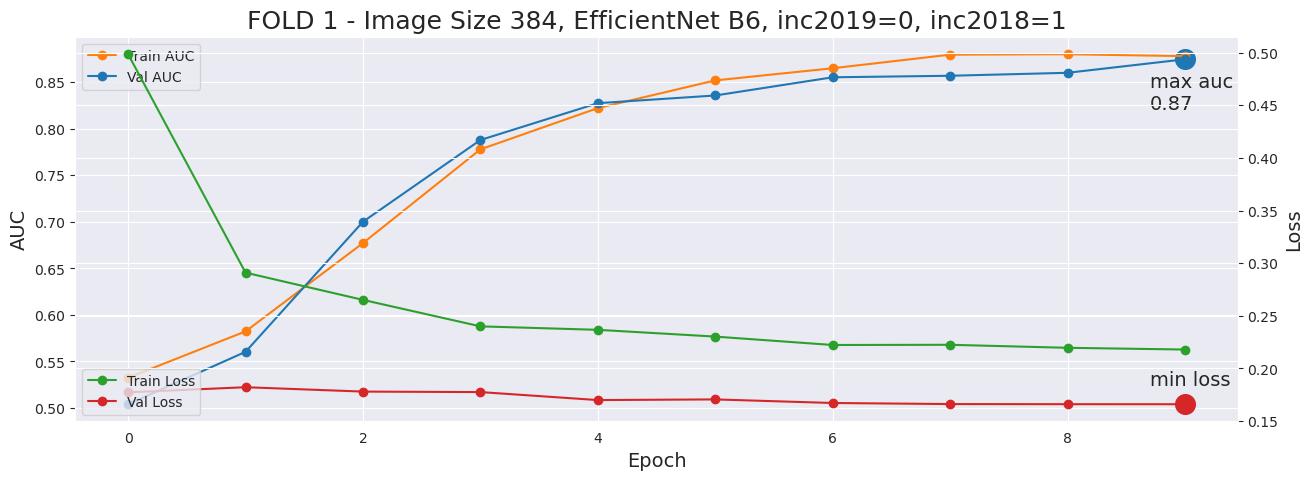

fold :  1  idxT :  [ 0  1  2  5  8  9 11 13]  idxV :  [ 3  4  6  7 10 12 14]
#########################
#### FOLD 2
#### Image Size 384 with EfficientNet B6 and batch_size 32
#### Using 2018+2017 external data
#########################
Training...
INFO:tensorflow:batch_all_reduce: 596 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 596 all-reduces with algorithm = nccl, num_packs = 1
Loading best model...
Predicting OOF with TTA...
Predicting Test with TTA...
#### FOLD 2 OOF AUC without TTA = 0.861, with TTA = 0.885


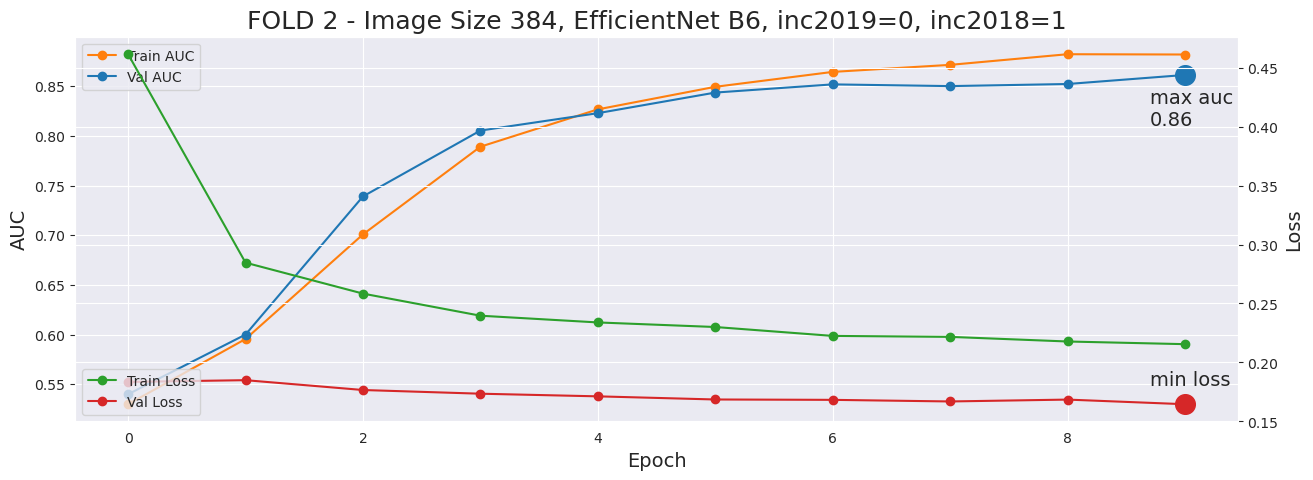

In [19]:
VERBOSE = 0
DISPLAY_PLOT = True

skf = KFold(n_splits = FOLDS,shuffle = True,random_state = SEED)
oof_pred = []; oof_tar = []; oof_val = []; oof_names = []; oof_folds = [] 
preds = np.zeros((count_data_items(files_test),1))

for fold,(idxT,idxV) in enumerate(skf.split(np.arange(15))):
    print('fold : ', fold, ' idxT : ', idxT, ' idxV : ',idxV)
    # DISPLAY FOLD INFO
    if DEVICE=='TPU':
        if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)
    print('#'*25); print('#### FOLD',fold+1)
    print('#### Image Size %i with EfficientNet B%i and batch_size %i'%
          (IMG_SIZES[fold],EFF_NETS[fold],BATCH_SIZES[fold]*REPLICAS))
    
    # CREATE TRAIN AND VALIDATION SUBSETS
    files_train = tf.io.gfile.glob([GCS_PATH[fold] + '/train%.2i*.tfrec'%x for x in idxT])
    if INC2019[fold]:
        files_train += tf.io.gfile.glob([GCS_PATH2[fold] + '/train%.2i*.tfrec'%x for x in idxT*2+1])
        print('#### Using 2019 external data')
    if INC2018[fold]:
        files_train += tf.io.gfile.glob([GCS_PATH2[fold] + '/train%.2i*.tfrec'%x for x in idxT*2])
        print('#### Using 2018+2017 external data')
    np.random.shuffle(files_train); print('#'*25)
    files_valid = tf.io.gfile.glob([GCS_PATH[fold] + '/train%.2i*.tfrec'%x for x in idxV])
    files_test = np.sort(np.array(tf.io.gfile.glob(GCS_PATH[fold] + '/test*.tfrec')))
    
    # BUILD MODEL
    K.clear_session()
    with strategy.scope():
        model = build_model(dim=IMG_SIZES[fold],ef=EFF_NETS[fold])
        
    # SAVE BEST MODEL EACH FOLD
    sv = tf.keras.callbacks.ModelCheckpoint(
        'fold-%i.h5'%fold, monitor='val_loss', verbose=0, save_best_only=True,
        save_weights_only=True, mode='min', save_freq='epoch')
   
    # TRAIN
    print('Training...')
    history = model.fit(
        get_dataset(
            files_train,
            augment = True, 
            shuffle = True, 
            repeat = True,
            dim = IMG_SIZES[fold],
            batch_size = BATCH_SIZES[fold]
        ), 
        epochs = EPOCHS[fold],
        callbacks = [sv,get_lr_callback(BATCH_SIZES[fold])], 
        steps_per_epoch = count_data_items(files_train) / BATCH_SIZES[fold]//REPLICAS,
        validation_data = get_dataset(
            files_valid,augment = False,
            shuffle = False,
            repeat = False,
            dim = IMG_SIZES[fold]
        ), # class_weight = {0:1,1:2},
        verbose = VERBOSE
    )
    
    print('Loading best model...')
    model.load_weights('fold-%i.h5'%fold)
    
    # PREDICT OOF USING TTA
    print('Predicting OOF with TTA...')
    ds_valid = get_dataset(files_valid,labeled=False,return_image_names=False,augment=True,
            repeat=True,shuffle=False,dim=IMG_SIZES[fold],batch_size=BATCH_SIZES[fold]*4)
    ct_valid = count_data_items(files_valid); STEPS = TTA * ct_valid/BATCH_SIZES[fold]/4/REPLICAS
    pred = model.predict(ds_valid,steps=STEPS,verbose=VERBOSE)[:TTA*ct_valid,] 
    oof_pred.append( np.mean(pred.reshape((ct_valid,TTA),order='F'),axis=1) )                 
    #oof_pred.append(model.predict(get_dataset(files_valid,dim=IMG_SIZES[fold]),verbose=1))
    
    # GET OOF TARGETS AND NAMES
    ds_valid = get_dataset(files_valid, augment=False, repeat=False, dim=IMG_SIZES[fold],
            labeled=True, return_image_names=True)
    oof_tar.append( np.array([target.numpy() for img, target in iter(ds_valid.unbatch())]) )
    oof_folds.append( np.ones_like(oof_tar[-1],dtype='int8')*fold )
    ds = get_dataset(files_valid, augment=False, repeat=False, dim=IMG_SIZES[fold],
                labeled=False, return_image_names=True)
    oof_names.append( np.array([img_name.numpy().decode("utf-8") for img, img_name in iter(ds.unbatch())]))
    
    # PREDICT TEST USING TTA
    print('Predicting Test with TTA...')
    ds_test = get_dataset(files_test,labeled=False,return_image_names=False,augment=True,
            repeat=True,shuffle=False,dim=IMG_SIZES[fold],batch_size=BATCH_SIZES[fold]*4)
    ct_test = count_data_items(files_test); STEPS = TTA * ct_test/BATCH_SIZES[fold]/4/REPLICAS
    pred = model.predict(ds_test,steps=STEPS,verbose=VERBOSE)[:TTA*ct_test,] 
    preds[:,0] += np.mean(pred.reshape((ct_test,TTA),order='F'),axis=1) * WGTS[fold]
    
    # REPORT RESULTS
    auc = roc_auc_score(oof_tar[-1],oof_pred[-1])
    oof_val.append(np.max( history.history['val_auc'] ))
    print('#### FOLD %i OOF AUC without TTA = %.3f, with TTA = %.3f'%(fold+1,oof_val[-1],auc))
    
    # PLOT TRAINING
    if DISPLAY_PLOT:
        plt.figure(figsize=(15,5))
        plt.plot(np.arange(EPOCHS[fold]),history.history['auc'],'-o',label='Train AUC',color='#ff7f0e')
        plt.plot(np.arange(EPOCHS[fold]),history.history['val_auc'],'-o',label='Val AUC',color='#1f77b4')
        x = np.argmax( history.history['val_auc'] ); y = np.max( history.history['val_auc'] )
        xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
        plt.scatter(x,y,s=200,color='#1f77b4'); plt.text(x-0.03*xdist,y-0.13*ydist,'max auc\n%.2f'%y,size=14)
        plt.ylabel('AUC',size=14); plt.xlabel('Epoch',size=14)
        plt.legend(loc=2)
        plt2 = plt.gca().twinx()
        plt2.plot(np.arange(EPOCHS[fold]),history.history['loss'],'-o',label='Train Loss',color='#2ca02c')
        plt2.plot(np.arange(EPOCHS[fold]),history.history['val_loss'],'-o',label='Val Loss',color='#d62728')
        x = np.argmin( history.history['val_loss'] ); y = np.min( history.history['val_loss'] )
        ydist = plt.ylim()[1] - plt.ylim()[0]
        plt.scatter(x,y,s=200,color='#d62728'); plt.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
        plt.ylabel('Loss',size=14)
        plt.title('FOLD %i - Image Size %i, EfficientNet B%i, inc2019=%i, inc2018=%i'%
                (fold+1,IMG_SIZES[fold],EFF_NETS[fold],INC2019[fold],INC2018[fold]),size=18)
        plt.legend(loc=3)
        plt.show() 

In [24]:
# COMPUTE OVERALL OOF AUC
oof = np.concatenate(oof_pred); true = np.concatenate(oof_tar);
names = np.concatenate(oof_names); folds = np.concatenate(oof_folds)
auc = roc_auc_score(true,oof)
print('Overall OOF AUC with TTA = %.3f'%auc)

# SAVE OOF TO DISK
df_oof = pd.DataFrame(dict(
    image_name = names, target=true, pred = oof, fold=folds))
df_oof.to_csv('oof.csv',index=False)
df_oof.head()

Overall OOF AUC with TTA = 0.877


,image_name,target,pred,fold
0,ISIC_2637011,0,0.020208,0
1,ISIC_0074311,0,0.017437,0
2,ISIC_0088137,0,0.020425,0
3,ISIC_0082348,0,0.020370,0
4,ISIC_0080817,0,0.042339,0


In [21]:
#Taking test set here to predict model accuracy
ds = get_dataset(files_test, augment=False, repeat=False, dim=IMG_SIZES[fold],
                 labeled=False, return_image_names=True)

image_names = np.array([img_name.numpy().decode("utf-8") 
                        for img, img_name in iter(ds.unbatch())])


In [22]:
#SAVE THE MODEL
model.save('/home/azureadmin/notebooks/data/saved_model_1/effnet_6_5_fold')

2022-09-22 15:24:26.963501: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/azureadmin/notebooks/data/saved_model_1/effnet_6_5_fold/assets


In [23]:
#Load the Model
new_model=tf.keras.models.load_model('/home/azureadmin/notebooks/data/saved_model_1/effnet_6_5_fold')

In [26]:
print(tf.__version__)

2.8.0
